In [6]:
%pip install grandalf
%pip install pyppeteer
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 900.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.2
    Uninstalling urllib3-2.2.2:
      Successfully uninstalled urllib3-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 2.8.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 30.1.0 which is incompatible.
tensorboard 2.11.2 requires protobuf<4,>=3.9.2, but you have protobuf 4.24.2 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 4.24.2 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<

In [5]:
%%capture --no-stderr
%pip install -U langgraph

In [33]:
import random
from typing import Annotated, Literal # annotated refers to that we can provide the additional
#information about how type is used and all, LIteral is usefull when the 
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    
class MyNode:
    
    def __init__(self, name: str):
        self.name = name
        
    def __call__(self, state: State):
        return { "messages": [("assistant", f"Called node{self.name}")]}

def route(State) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"

def add_fractal_nodes(builder, current_node, level ,max_level):
    if level> max_level:
        return
    
    num_nodes = random.randint(1, 3 )
    for i in range(num_nodes):
        nm = ["A", "B", "C"] [i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)
        
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level +1, max_level)
        elif r> 0.5:
            builder.add_conditional_edges(node_name, route, node_name)
        else: 
            builder.add_edge(node_name, "__end__")
            
            
def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = " entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)
    
    add_fractal_nodes(builder, entry_point, 1, max_level)
    
    builder.add_edge(entry_point, END)
    return builder.compile()

app = build_fractal_graph(3)


In [28]:
import random
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge(START, entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, END)  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)


In [34]:
app.get_graph().print_ascii()

                                                                  +-----------+                                                      
                                                                  | __start__ |                                                      
                                                                  +-----------+                                                      
                                                                         *                                                           
                                                                         *                                                           
                                                                         *                                                           
                                                                 +-------------+                                                     
                                                              

In [35]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([__start__]):::first
	_entry_node( entry_node)
	node__entry_node_A(node_ entry_node_A)
	node_node__entry_node_A_A(node_node_ entry_node_A_A)
	node_node__entry_node_A_B(node_node_ entry_node_A_B)
	node_node__entry_node_A_C(node_node_ entry_node_A_C)
	__end__([__end__]):::last
	_entry_node --> __end__;
	_entry_node --> node__entry_node_A;
	__start__ --> _entry_node;
	node__entry_node_A --> node_node__entry_node_A_A;
	node__entry_node_A --> node_node__entry_node_A_B;
	node__entry_node_A --> node_node__entry_node_A_C;
	node_node__entry_node_A_A --> __end__;
	node_node__entry_node_A_B --> __end__;
	node_node__entry_node_A_C --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



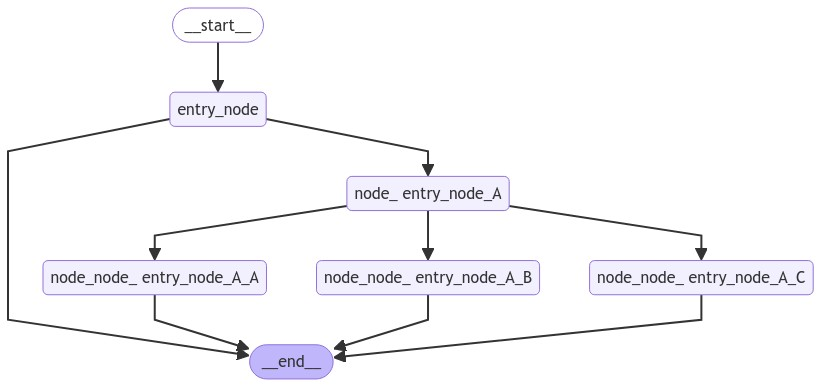

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)